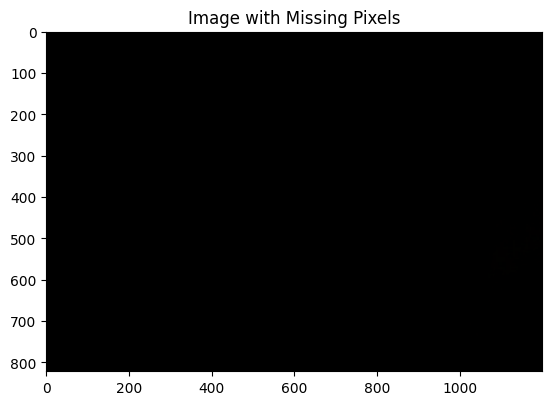

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.kernel_approximation import RBFSampler
from PIL import Image
from numba import njit

# Load and normalize the image
def load_image(path):
    img = Image.open(path)
    img = np.array(img, dtype=np.float64) / 255  # Normalize image pixels
    return img

# Function to remove random pixels from an RGB image
def remove_random_pixels_rgb(image, num_pixels=900):
    missing_image = image.copy()
    height, width, _ = image.shape

    # Remove the same pixels across all RGB channels
    indices = np.random.choice(height * width, num_pixels, replace=False)
    row_indices, col_indices = np.unravel_index(indices, (height, width))

    missing_image[row_indices, col_indices, :] = 0  # Set all channels to 0

    plt.imshow(missing_image.astype(np.uint8))
    plt.title("Image with Missing Pixels")
    plt.show()

    return missing_image, indices

@njit
def update_uv(U, V, eij, i, j, alpha, beta):
    for k in range(len(i)):
        U[i[k]] += alpha * (2 * eij[k] * V[j[k]] - beta * U[i[k]])
        V[j[k]] += alpha * (2 * eij[k] * U[i[k]] - beta * V[j[k]])

# Matrix Factorization using SGD for RGB images
def matrix_factorization_sgd_rgb(image, rank, steps=50, alpha=0.0002, beta=0.02):
    m, n, c = image.shape
    reconstructed_image = np.zeros((m, n, c))

    for channel in range(c):
        image_channel = image[:, :, channel]
        U = np.random.rand(m, rank)
        V = np.random.rand(n, rank)

        non_zero = np.argwhere(image_channel > 0)

        for step in range(steps):
            np.random.shuffle(non_zero)
            i, j = non_zero[:, 0], non_zero[:, 1]
            eij = image_channel[i, j] - np.dot(U[i], V[j].T)
            update_uv(U, V, eij, i, j, alpha, beta)

        reconstructed_channel = np.dot(U, V.T)
        reconstructed_image[:, :, channel] = np.clip(reconstructed_channel, 0, 255)

    return reconstructed_image

# Reconstruct using RFF + Linear Regression for RGB images
def rff_reconstruction_rgb(image, missing_image, num_samples=100, gamma=0.1):
    m, n, c = image.shape
    reconstructed_image = np.zeros((m, n, c))

    for channel in range(c):
        X = np.argwhere(missing_image[:, :, channel] > 0)
        y = image[:, :, channel][missing_image[:, :, channel] > 0]

        rbf_sampler = RBFSampler(gamma=gamma, n_components=num_samples)
        X_features = rbf_sampler.fit_transform(X)

        reg = LinearRegression()
        reg.fit(X_features, y)

        all_pixel_locations = np.indices((m, n)).reshape(2, -1).T
        all_features = rbf_sampler.transform(all_pixel_locations)
        reconstructed_channel = reg.predict(all_features).reshape(m, n)

        reconstructed_image[:, :, channel] = np.clip(reconstructed_channel, 0, 255)

    return reconstructed_image

# Load the image
image_path = "/content/13549827_web1_180914-CDT-booknotes.jpg"  # Update path as needed
image = load_image(image_path)

# Remove 900 random pixels
missing_image, missing_indices = remove_random_pixels_rgb(image)

# Perform matrix factorization on the image with missing pixels
rank = 10
reconstructed_image = matrix_factorization_sgd_rgb(missing_image, rank)

# Plot original and reconstructed images
plt.subplot(1, 2, 1)
plt.imshow(image.astype(np.uint8))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image.astype(np.uint8))
plt.title("Reconstructed Image")
plt.show()

# RMSE and PSNR calculations
def rmse_rgb(original, reconstructed):
    return np.sqrt(mean_squared_error(original.flatten(), reconstructed.flatten()))

def psnr_rgb(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    return 20 * np.log10(255.0 / np.sqrt(mse)) if mse > 0 else 100

# Compute and print RMSE and PSNR
rmse_value = rmse_rgb(image, reconstructed_image)
psnr_value = psnr_rgb(image, reconstructed_image)
print(f"RMSE: {rmse_value}, PSNR: {psnr_value}")

# Run the RFF-based reconstruction on RGB images
reconstructed_rff_rgb = rff_reconstruction_rgb(image, missing_image)

# Calculate RMSE and PSNR for RFF reconstruction
rmse_rff_rgb = rmse_rgb(image, reconstructed_rff_rgb)
psnr_rff_rgb = psnr_rgb(image, reconstructed_rff_rgb)

# Plot the reconstructed image from RFF
plt.imshow(reconstructed_rff_rgb.astype(np.uint8))
plt.title("Reconstructed with Missing Pixels (RFF)")
plt.show()

# Print RMSE and PSNR values for RFF
print(f"RMSE (RFF): {rmse_rff_rgb}, PSNR (RFF): {psnr_rff_rgb}")